In [1]:
import tweepy
import json
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from threading import Thread
import queue
from datetime import datetime
import concurrent.futures
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from benfordslaw import benfordslaw
from getpass import getpass

In [2]:
consumer_key = str(getpass("Enter the API Key"))
consumer_secret = str(getpass("Enter the Secret Key"))

Enter the API Key········
Enter the Secret Key········


In [3]:
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
# redirect_url = auth.get_authorization_url()
# print("Open the following link to authorize: ")
# print(redirect_url)
# bot.get(redirect_url)

# user_pint_input = input("Enter PIN: ")
# auth.get_access_token(user_pint_input)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
print("Logged in")

Logged in


In [4]:
# Extracting WOEID of cities

all_cities = ['Delhi', 'Hyderabad']
all_woeid = {}
trends = api.trends_available()
for i in range(len(trends)): 
    if(trends[i]['name'] in all_cities):
        all_woeid[trends[i]['name']] = trends[i]['woeid']  

#Getting top trends in cities
del_trends = api.trends_place(all_woeid['Delhi'])
hyd_trends = api.trends_place(all_woeid['Hyderabad'])

# Best trend
del_best_trend = del_trends[0]['trends'][1]
print("Delhi Best Trend:", del_best_trend['name'])

hyd_best_trend = hyd_trends[0]['trends'][1]
print("Hyderabad Best Trend:", hyd_best_trend['name'])

num_tweets = int(input("Number of Tweets to be extracted: "))

Delhi Best Trend: Dada
Hyderabad Best Trend: #SouravGanguly
Number of Tweets to be extracted: 1000


In [5]:
def extract_tweets(city_statuses):
    search_results = []
    while True:
        try:
            status = city_statuses.next()
            search_results.append(status._json)
        except tweepy.TweepError:
            time.sleep(60*15)
            continue
        except StopIteration:
            return search_results


# del_statuses = tweepy.Cursor(api.search, q=del_best_trend['query'], geocode="28.64386,77.12373,100mi").items(num_tweets)
# hyd_statuses = tweepy.Cursor(api.search, q=hyd_best_trend['query'], geocode="17.40633,78.46276,100mi").items(num_tweets)

del_statuses = tweepy.Cursor(api.search, q=del_best_trend['query']).items(num_tweets)
hyd_statuses = tweepy.Cursor(api.search, q=hyd_best_trend['query']).items(num_tweets)

param_list = [del_statuses, hyd_statuses]

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(extract_tweets, param) for param in param_list]

all_futures = [f.result() for f in futures]
del_search_results = all_futures[0]
hyd_search_results = all_futures[1]


# Saving tweets
with open('del_tweets.json', 'w', encoding='utf-8') as f:
    json.dump(del_search_results, f, indent = 4, ensure_ascii=False)

with open('hyd_tweets.json', 'w', encoding='utf-8') as f:
    json.dump(hyd_search_results, f, indent = 4, ensure_ascii=False)
    
print("Extracted ", len(del_search_results), " top trending tweets from Delhi")
print("Extracted ", len(hyd_search_results), " top trending tweets from Hyderabad")


Extracted  1000  top trending tweets from Delhi
Extracted  1000  top trending tweets from Hyderabad


In [6]:
import math
def calc_score(followers, friends, retweets):
    ratio = math.log1p(float(followers)*float(friends))
    return ratio

def make_pandas(search_results):
    res = list()
    for i in search_results:
        sample = [i['user']['screen_name'], i['user']['followers_count'], i['user']['friends_count'], calc_score(i['user']['followers_count'], i['user']['friends_count'], i['retweet_count']), i['user']['favourites_count'], i['retweet_count'], i['lang'], i['user']['verified']]
        all_hash = ['#' + tags['text'] for tags in i['entities']['hashtags']]
        sample.append(all_hash)
#         sample.append(i['text'])
        res.append(sample)
    
    res = pd.DataFrame(res,columns=['user_name', 'followers_count', 'friends_count', 'score', 'likes_count', 'retweet_count', 'lang', 'verified', 'all_tags'])
    return res

del_pandas = make_pandas(del_search_results)
hyd_pandas = make_pandas(hyd_search_results)


## User Data with custom reach score

In [7]:

del_pandas.sort_values(by=['score'], ascending=False)[:20]

,user_name,followers_count,friends_count,score,likes_count,retweet_count,lang,verified,all_tags
409,IndiaToday,5452058,245,21.012762,4439,2,en,True,[]
815,RukamkeshBarwal,18248,14282,19.378566,9962,0,en,False,[#Dada]
520,RukamkeshBarwal,18248,14282,19.378566,9962,0,hi,False,[#BCCI]
820,lionsdenkxip,2245894,106,19.288053,3129,21,en,True,[]
311,jeet30,1235533,153,19.057451,693,9,en,True,[]
376,IndiaTodayFLASH,1124560,117,18.695076,135,2,en,True,[]
460,annodomin1,10824,8888,18.381979,11425,8,en,False,[#SouravGanguly]
406,sri_stuntman,16242,5526,18.312575,9446,1,en,False,[#Kolkata]
725,Senthil__VJ,13288,6515,18.276479,237271,135,en,False,[]
809,akash207,20042,4202,18.248901,7197,0,en,True,[#SouravGanguly]


In [8]:
hyd_pandas.sort_values(by=['score'], ascending=False)[:20]

,user_name,followers_count,friends_count,score,likes_count,retweet_count,lang,verified,all_tags
623,tiwarymanoj,2878063,1292,22.036575,33771,18,en,True,[#GetWellSoonDada]
518,IndiaToday,5452058,245,21.012762,4439,6,en,True,"[#SouravGanguly, #Kolkata]"
694,IndiaToday,5452058,245,21.012762,4439,3,en,True,[]
71,IndiaToday,5452057,245,21.012762,4439,2,en,True,[]
487,AilsaForshaw,15675,16736,19.385140,209473,6,en,False,"[#SouravGanguly, #Kolkata]"
88,RukamkeshBarwal,18248,14282,19.378566,9962,0,hi,False,[#BCCI]
766,NewIndianXpress,459782,551,19.350243,547,2,en,True,[#SouravGanguly]
479,ndtv,14331212,16,19.250539,2,8,en,True,[#SouravGanguly]
712,MiLOKMAT,311053,527,18.914919,3019,1,mr,True,"[#SouravGanguly, #Dada, #BCCI]"
504,IndiaTodayFLASH,1124560,117,18.695076,135,6,en,True,"[#SouravGanguly, #Kolkata]"



## Language distribution of users

Delhi data
 [['bn' '1']
 ['de' '1']
 ['en' '869']
 ['es' '11']
 ['et' '6']
 ['hi' '17']
 ['ht' '1']
 ['in' '19']
 ['iw' '3']
 ['ja' '12']
 ['ko' '5']
 ['mr' '2']
 ['pl' '2']
 ['pt' '11']
 ['ta' '20']
 ['th' '5']
 ['tl' '9']
 ['tr' '1']
 ['und' '5']]


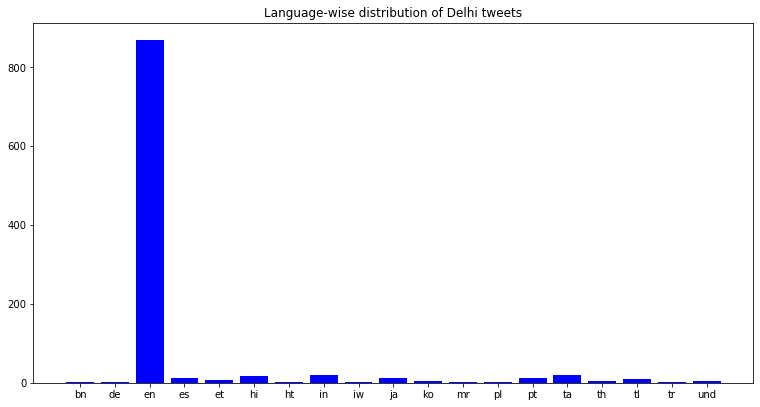

Hyderabad data
 [['bn' '15']
 ['en' '712']
 ['es' '1']
 ['et' '1']
 ['gu' '6']
 ['hi' '213']
 ['in' '2']
 ['kn' '1']
 ['mr' '8']
 ['ta' '11']
 ['te' '4']
 ['tl' '5']
 ['und' '21']]


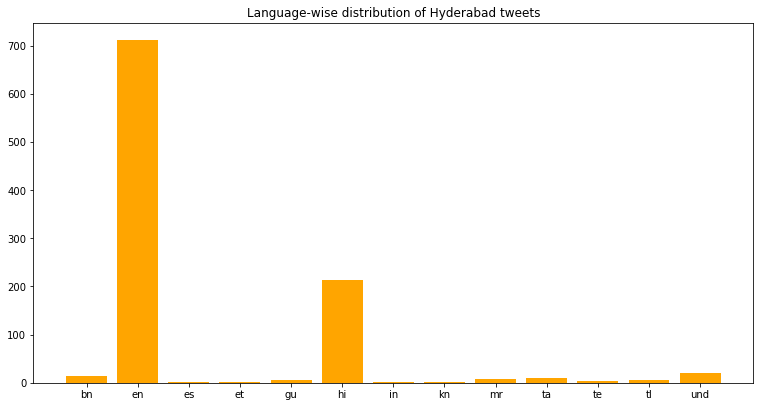

In [9]:
#hyderabad delhi frequency plot
lang_dict = { 'hi' :'Hindi','en' :'English','or' :'Oriya','ta':'Tamil','und': 'Unidentified'}
lang_list = np.array([del_search_results[i]['lang'] for i in range(len(del_search_results))])
unique, counts = np.unique(lang_list, return_counts=True)
print("Delhi data\n", np.asarray((unique, counts)).T)

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(unique,counts, color='blue')
plt.title("Language-wise distribution of Delhi tweets")
plt.show()

#hyderabad language frequency plot
lang_list = np.array([hyd_search_results[i]['lang'] for i in range(len(hyd_search_results))])
unique, counts = np.unique(lang_list, return_counts=True)
print("Hyderabad data\n", np.asarray((unique, counts)).T)

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(unique,counts, color='orange')
plt.title("Language-wise distribution of Hyderabad tweets")
plt.show()

[benfordslaw] >[chi2] Anomaly detected! P=0.0246769, Tstat=17.5717


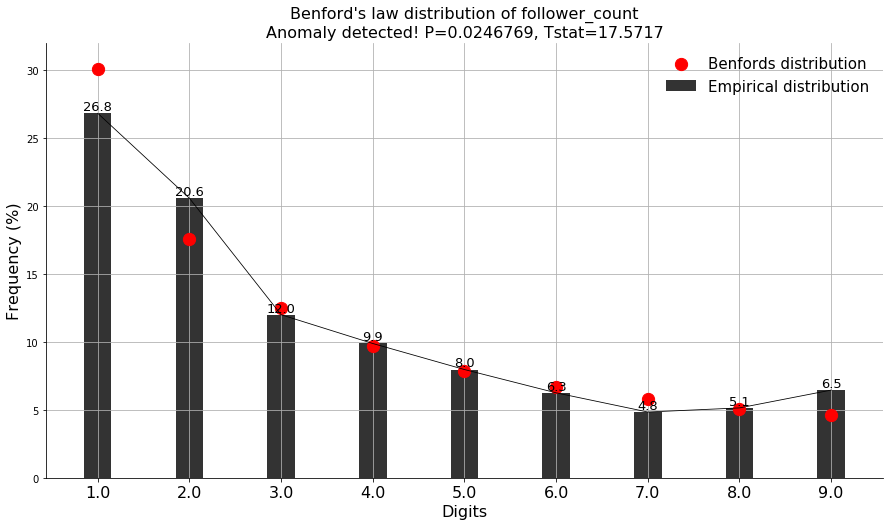

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc6a8680150>)

In [10]:
bl = benfordslaw()
results = bl.fit(del_pandas['friends_count'])
bl.plot(title='Benford\'s law distribution of follower_count')